In [1]:
# Libraries
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics         import mean_squared_error
from sklearn.tree            import DecisionTreeRegressor
from sklearn.preprocessing   import StandardScaler
from sklearn.utils           import resample
from sklearn.ensemble        import AdaBoostRegressor

warnings.filterwarnings('ignore')

In [2]:
# local file paths

dir_name = 'selezione'
region_names = np.array(['A', 'B', 'C'])
region_ids   = np.array(['1286', '2061', '3101'])

fp_Xtrain = []
fp_Xval   = []
fp_Xtest  = []
fp_ytrain = []
fp_yval   = []
fp_ytest  = []

for i in range(3):
    fp_Xtrain.append(dir_name + f'/X_train{region_names[i]}.csv')
    fp_Xval  .append(dir_name + f'/X_val{  region_names[i]}.csv')
    fp_Xtest .append(dir_name + f'/X_test{ region_names[i]}.csv')
    fp_ytrain.append(dir_name + f'/y_train{region_names[i]}.csv')
    fp_yval  .append(dir_name + f'/y_val{  region_names[i]}.csv')
    fp_ytest .append(dir_name + f'/y_test{ region_names[i]}.csv')

In [3]:
# Lettura dei dati

X_train = []
X_val   = []
X_test  = []
y_train = []
y_val   = []
y_test  = []

for i in range(3):
    X_train.append(pd.read_csv(fp_Xtrain[i], low_memory=False))
    X_val  .append(pd.read_csv(fp_Xval  [i], low_memory=False))        
    X_test .append(pd.read_csv(fp_Xtest [i], low_memory=False))
    y_train.append(pd.read_csv(fp_ytrain[i], low_memory=False))
    y_val  .append(pd.read_csv(fp_yval  [i], low_memory=False))        
    y_test .append(pd.read_csv(fp_ytest [i], low_memory=False))
    
X_train = np.array(X_train, dtype=object)
X_val   = np.array(X_val,   dtype=object)
X_test  = np.array(X_test,  dtype=object)
y_train = np.array(y_train, dtype=object)
y_val   = np.array(y_val,   dtype=object)
y_test  = np.array(y_test,  dtype=object)

In [4]:
def dimensionality(y=False):
    for i in range(3):
        print(f'X_train{region_names[i]}: {X_train[i].shape}')
        print(f'X_val{region_names[i]}:   {X_val  [i].shape}')
        print(f'X_test{region_names[i]}:  {X_test [i].shape}')
        if y:
            print(f'y_train{region_names[i]}: {y_train[i].shape}')
            print(f'y_val{region_names[i]}:   {y_val  [i].shape}')
            print(f'y_test{region_names[i]}:  {y_test [i].shape}')
        print()

In [5]:
dimensionality(y=True)

X_trainA: (26819, 41)
X_valA:   (9006, 41)
X_testA:  (9085, 41)
y_trainA: (26819, 1)
y_valA:   (9006, 1)
y_testA:  (9085, 1)

X_trainB: (8119, 34)
X_valB:   (2658, 34)
X_testB:  (2606, 34)
y_trainB: (8119, 1)
y_valB:   (2658, 1)
y_testB:  (2606, 1)

X_trainC: (64771, 48)
X_valC:   (21908, 48)
X_testC:  (21876, 48)
y_trainC: (64771, 1)
y_valC:   (21908, 1)
y_testC:  (21876, 1)



Per limiti tecnici di memoria, la gestione del dataset C risulta complicata e incorre spesso in errori a run-time di cateoria __MemoryError__

Le macchine su cui sono eseguiti i notebook supportano operazioni su circa 30000 righe, quindi uso i 2/5 del dataset originale per la Regione C

In [6]:
perc = 2/5
ind  = 2
for X, y in zip([X_train, X_val, X_test], [y_train, y_val, y_test]):
    X[ind], y[ind] = resample(
        X[ind], y[ind],
        n_samples = int(perc * len(X[2]))
    )

In [7]:
dimensionality(y=True)

X_trainA: (26819, 41)
X_valA:   (9006, 41)
X_testA:  (9085, 41)
y_trainA: (26819, 1)
y_valA:   (9006, 1)
y_testA:  (9085, 1)

X_trainB: (8119, 34)
X_valB:   (2658, 34)
X_testB:  (2606, 34)
y_trainB: (8119, 1)
y_valB:   (2658, 1)
y_testB:  (2606, 1)

X_trainC: (25908, 48)
X_valC:   (8763, 48)
X_testC:  (8750, 48)
y_trainC: (25908, 1)
y_valC:   (8763, 1)
y_testC:  (8750, 1)



# Insieme di costruzione del modello

In [8]:
#sub_perc = [1/1000, 1/100, 1/1000] # circa 100, per testing, 2 minuti
#sub_perc = [   1/3,     1,    1/3] # circa 8000, mezz'ora
sub_perc = [     1,     1,      1] # dataset completo, quattro ore

In [9]:
for i in range(3):
    print(int(len(X_train[i])*sub_perc[i]))
    print(int(len(X_val  [i])*sub_perc[i]))
    print()

26
9

81
26

25
8



In [10]:
X_train_sub = []
y_train_sub = []
X_val_sub = []
y_val_sub = []

In [11]:
for i in range(3):
    Xt_sub, yt_sub = resample(X_train[i], y_train[i], n_samples = int(sub_perc[i]*len(X_train[i])))
    Xv_sub, yv_sub = resample(X_val  [i], y_val  [i], n_samples = int(sub_perc[i]*len(X_val[i])))
    X_train_sub.append(Xt_sub)
    y_train_sub.append(yt_sub)
    X_val_sub  .append(Xv_sub)
    y_val_sub  .append(yv_sub)

In [56]:
def dimensionality_sub(y=False):
    for i in range(3):
        print(f'X_train_sub{region_names[i]}: {X_train_sub[i].shape}')
        print(f'X_val_sub{region_names[i]}:   {X_val_sub  [i].shape}')
        if y:
            print(f'y_train_sub{region_names[i]}: {y_train_sub[i].shape}')
            print(f'y_val_sub{region_names[i]}:   {y_val_sub  [i].shape}')
        print()

In [57]:
dimensionality_sub(y=True)

X_train_subA: (26, 41)
X_val_subA:   (9, 41)
y_train_subA: (26, 1)
y_val_subA:   (9, 1)

X_train_subB: (81, 34)
X_val_subB:   (26, 34)
y_train_subB: (81, 1)
y_val_subB:   (26, 1)

X_train_subC: (25, 48)
X_val_subC:   (8, 48)
y_train_subC: (25, 1)
y_val_subC:   (8, 1)



# Costruzione DecisionTreeRegressor #

In [12]:
plt.rcParams.update({'font.size': 35})

In [13]:
def get_bias_var_mse(X, y, model):
        y_pred = model.predict(X)
        return {
            'bias': ((y - np.mean(y_pred))**2).mean(),\
            'var':  np.var(y_pred).mean(),\
            'mse':  ((y_pred - y.reshape(-1,1))**2).mean()
        }

In [14]:
# Costruzione Decision TreeRegressor
def DecisionTreeRegressor_validation(X_train, y_train, X_val, y_val, verbose=False, debug=False, file_name=''):
    
    def get_dec_tree_reg(max_leaf):
        dt = DecisionTreeRegressor(
            max_leaf_nodes = max_leaf#,
            #criterion = 'absolute_error'
        )
        dt.fit(X_train, y_train)
        return dt
    
    def bias_var_mse(X, y, model):
        stats = get_bias_var_mse(X, y, model)
        return stats['bias'],\
               stats['var'],\
               stats['mse']
    
    def plot_mse(stats, name):
    
        print (f'{name}: TUNING DEL MASSIMO NUMERO DI FOGLIE')
        print()
    
        for n in ['mse', 'bias', 'var']:
        
            min_  = min(stats[n])
            best  = (np.argmin(stats[n]) * STEP) + START
            
            print (f'Punteggio finale: {stats[n][-1]} ({END}) MaxLeaves')
            print (f'Best {n}: {min_}')
            print (f'Best number of MaxLeaves: {best}')
            print()

        fig, ax = plt.subplots(figsize=(len(stats['mse'])/2, 10))
        
        ax.tick_params(axis='both', which='major', labelsize=25)
        ax.tick_params(axis='both', which='minor', labelsize=15)
        
        ax.plot(range(START, END+1, STEP),  stats['mse' ], 'o-', label='MSE')
        ax.plot(range(START, END+1, STEP),  stats['bias'], 'o-', label='BIAS')
        ax.plot(range(START, END+1, STEP),  stats['var' ], 'o-', label='VARIANCE')
        
        ax.set_title(f"{name} MSE, BIAS, VARIANCE on different MaxLeaves", fontsize=15)
        ax.set_xlabel("Number of Max Leaves used", fontsize=15)
        ax.grid()
        ax.legend(prop={'size': 12})
        
        if file_name != '':
            fig.savefig('images/' + file_name + '_DecisionTreeRegressor_' + name + '.jpg')
        
    y_train = y_train.values.ravel()
    y_val   = y_val  .values.ravel()

    START =    5
    END   =  500
    STEP  =    5
    
    model_start = get_dec_tree_reg(START)
    
    _, _, best_mse = bias_var_mse(X_val, y_val, model_start)
    
    best_max_leaf   = START
    best_model      = model_start
    
    info         = []
    
    train_stats  = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    }
    
    val_stats    = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    } 
    
    for max_leaf in range(START, END+1, STEP):
        
        if debug:
            print(f'{max_leaf}/{END}')
    
        model = get_dec_tree_reg(max_leaf)
        
        trn_bias, trn_var, trn_mse = bias_var_mse(X_train, y_train, model)
        val_bias, val_var, val_mse = bias_var_mse(  X_val,   y_val, model)

        train_stats['bias'].append(trn_bias)
        train_stats['var' ].append(trn_var )
        train_stats['mse' ].append(trn_mse )
        
        val_stats['bias'].append(val_bias)
        val_stats['var' ].append(val_var )
        val_stats['mse' ].append(val_mse )
        
        info.append(f'Max Leaf: {max_leaf}' +\
                    f'\n(Train MSE:       {trn_mse }  - Val MSE:      {val_mse })' +\
                    f'\n(Train Bias:      {trn_bias}  - Val Bias:     {val_bias})' +\
                    f'\n(Train Variance:  {trn_var }  - Val Variance: {val_var })' )
        
        if debug:
            print(f'{max_leaf}/{END}')

        if(val_mse < best_mse):
            best_mse = val_mse
            best_max_leaf = max_leaf
            best_model = model
    
    if verbose:
        print()
        print(f'{name} MSE, BIAS, VARIANCE Train e Validation')
        print(*info, sep='\n')
        print()
        
    plot_mse(train_stats, "Train"     )
    plot_mse(  val_stats, "Validation")
                
    return best_model

In [15]:
dt_model = []

In [1]:
def get_dt(index, verbose=False, debug=False, file_name=''):
    if file_name == '':
        file_name = region_ids[index]
    return DecisionTreeRegressor_validation(
        X_train_sub[index],
        y_train_sub[index],
        X_val_sub  [index],
        y_val_sub  [index],
        verbose   = verbose,
        debug     = debug,
        file_name = file_name
    )

Train: TUNING DEL MASSIMO NUMERO DI FOGLIE

Punteggio finale: 0.015405368264813682 (500) MaxLeaves
Best mse: 0.014605896453180884
Best number of MaxLeaves: 5

Punteggio finale: 0.007702684132406841 (500) MaxLeaves
Best bias: 0.007702684132406841
Best number of MaxLeaves: 5

Punteggio finale: 0.007702684132406841 (500) MaxLeaves
Best var: 0.006903212320774046
Best number of MaxLeaves: 5

Validation: TUNING DEL MASSIMO NUMERO DI FOGLIE

Punteggio finale: 0.004769805322421128 (500) MaxLeaves
Best mse: 0.0044363081443342806
Best number of MaxLeaves: 305

Punteggio finale: 0.003325080915449576 (500) MaxLeaves
Best bias: 0.003323154838943403
Best number of MaxLeaves: 135

Punteggio finale: 0.001444724406971552 (500) MaxLeaves
Best var: 0.0011131511111111111
Best number of MaxLeaves: 305

Wall time: 838 ms


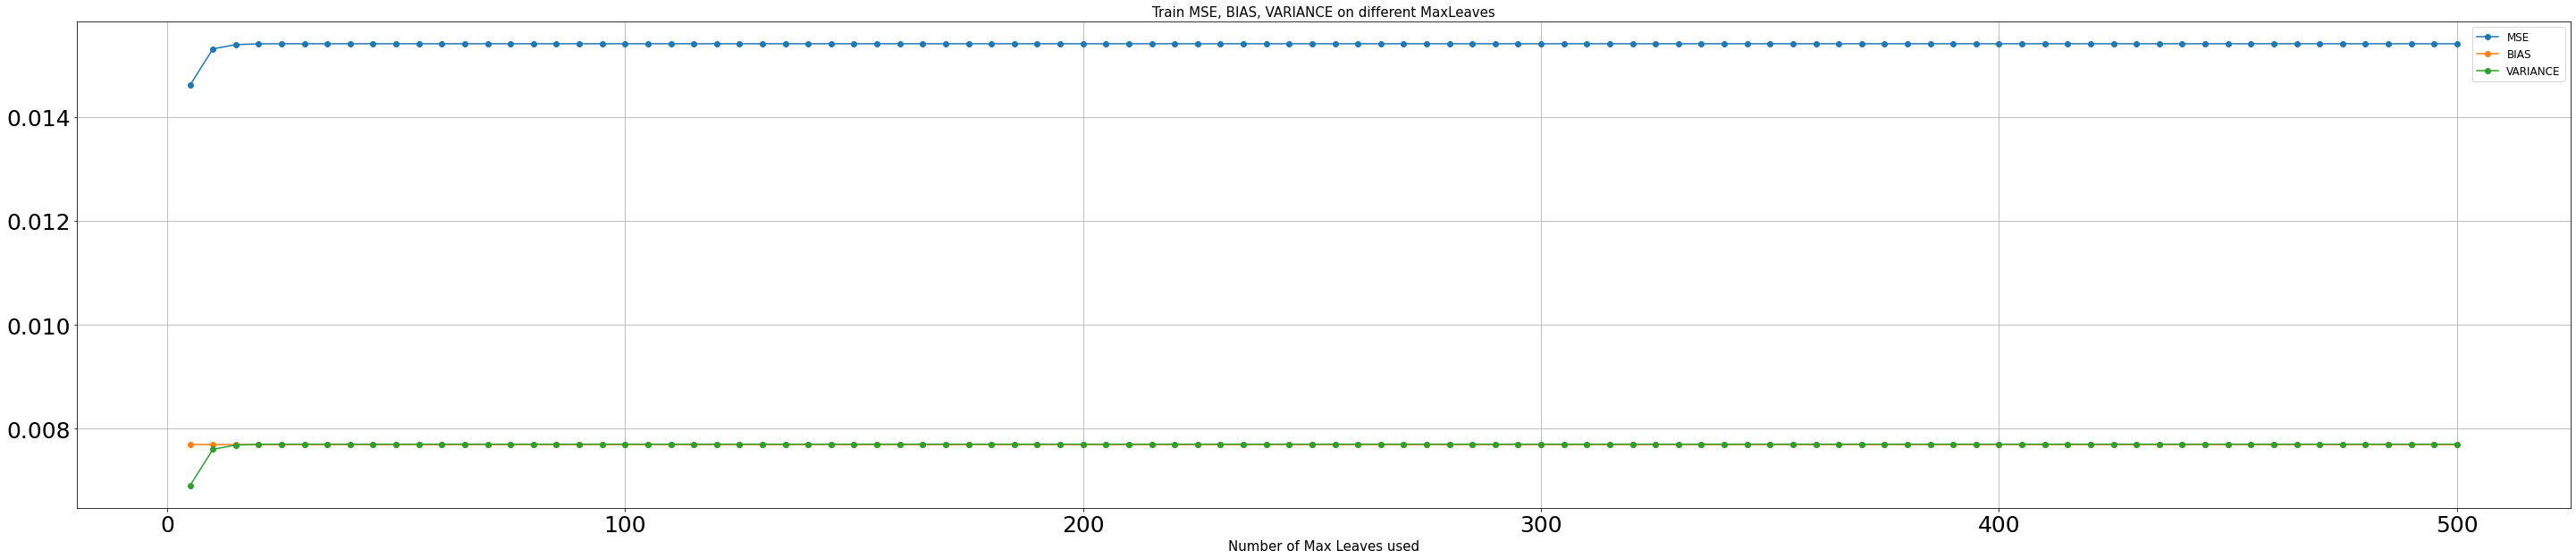

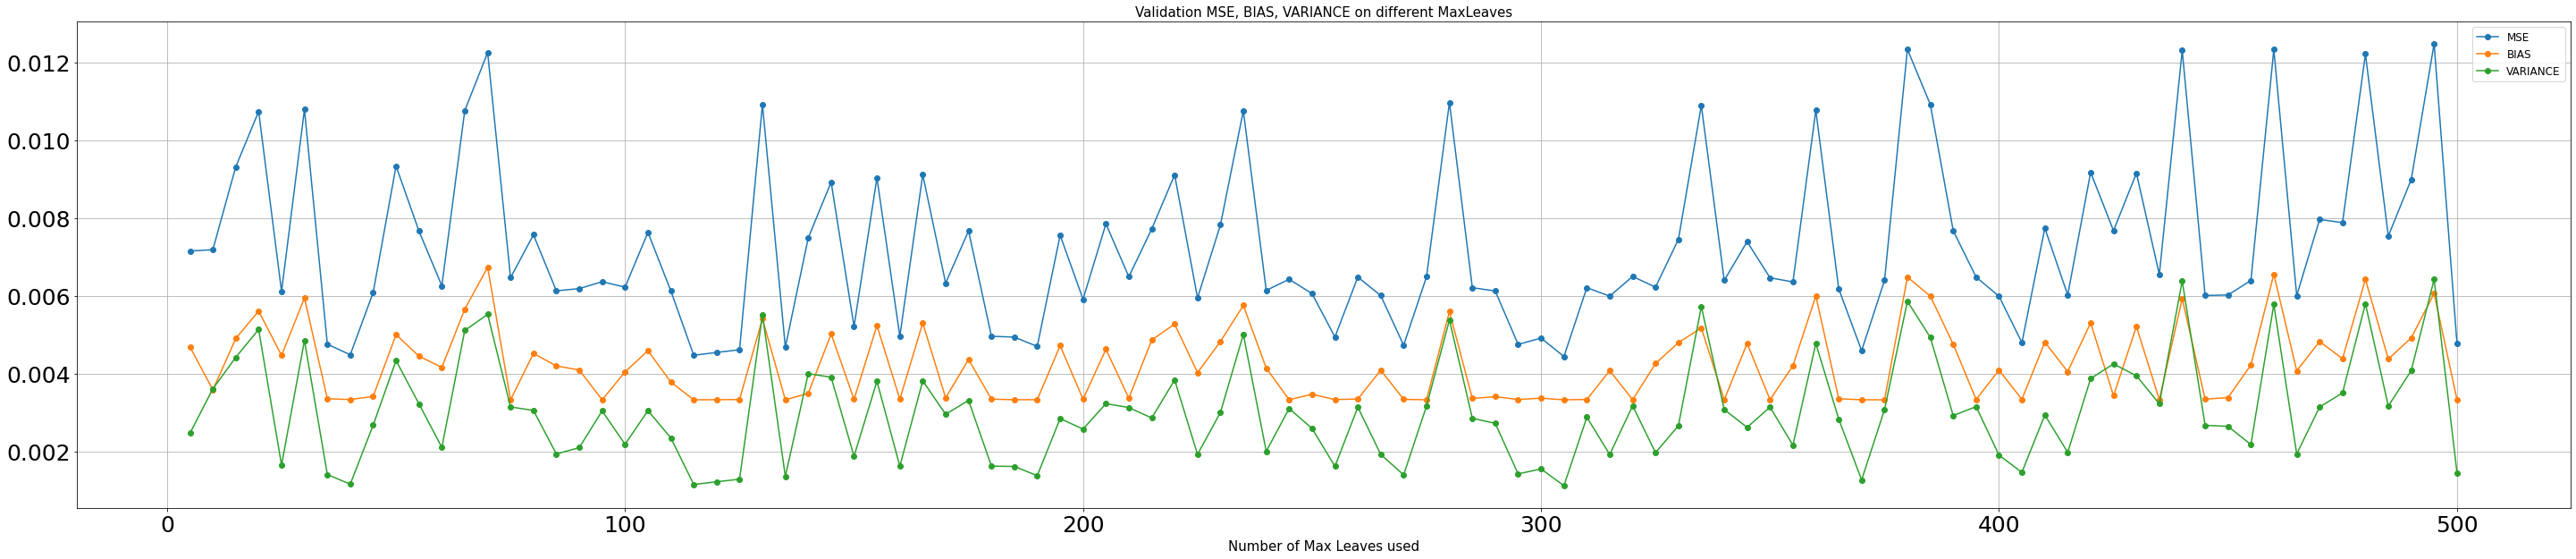

In [17]:
%%time
dt_model.append(
    get_dt(
        0,
        verbose   = False,
        debug     = False#,
        #file_name = 'prova0'
    )
)

Train: TUNING DEL MASSIMO NUMERO DI FOGLIE

Punteggio finale: 0.01091552452654047 (500) MaxLeaves
Best mse: 0.007807328300016054
Best number of MaxLeaves: 5

Punteggio finale: 0.005457762263270234 (500) MaxLeaves
Best bias: 0.005457762263270234
Best number of MaxLeaves: 5

Punteggio finale: 0.005457762263270234 (500) MaxLeaves
Best var: 0.0023495660367458186
Best number of MaxLeaves: 5

Validation: TUNING DEL MASSIMO NUMERO DI FOGLIE

Punteggio finale: 0.012358757442294838 (500) MaxLeaves
Best mse: 0.006956429889667195
Best number of MaxLeaves: 5

Punteggio finale: 0.005055873596183647 (500) MaxLeaves
Best bias: 0.0045854553417334866
Best number of MaxLeaves: 390

Punteggio finale: 0.00730288384611119 (500) MaxLeaves
Best var: 0.0019531610641338715
Best number of MaxLeaves: 5

Wall time: 688 ms


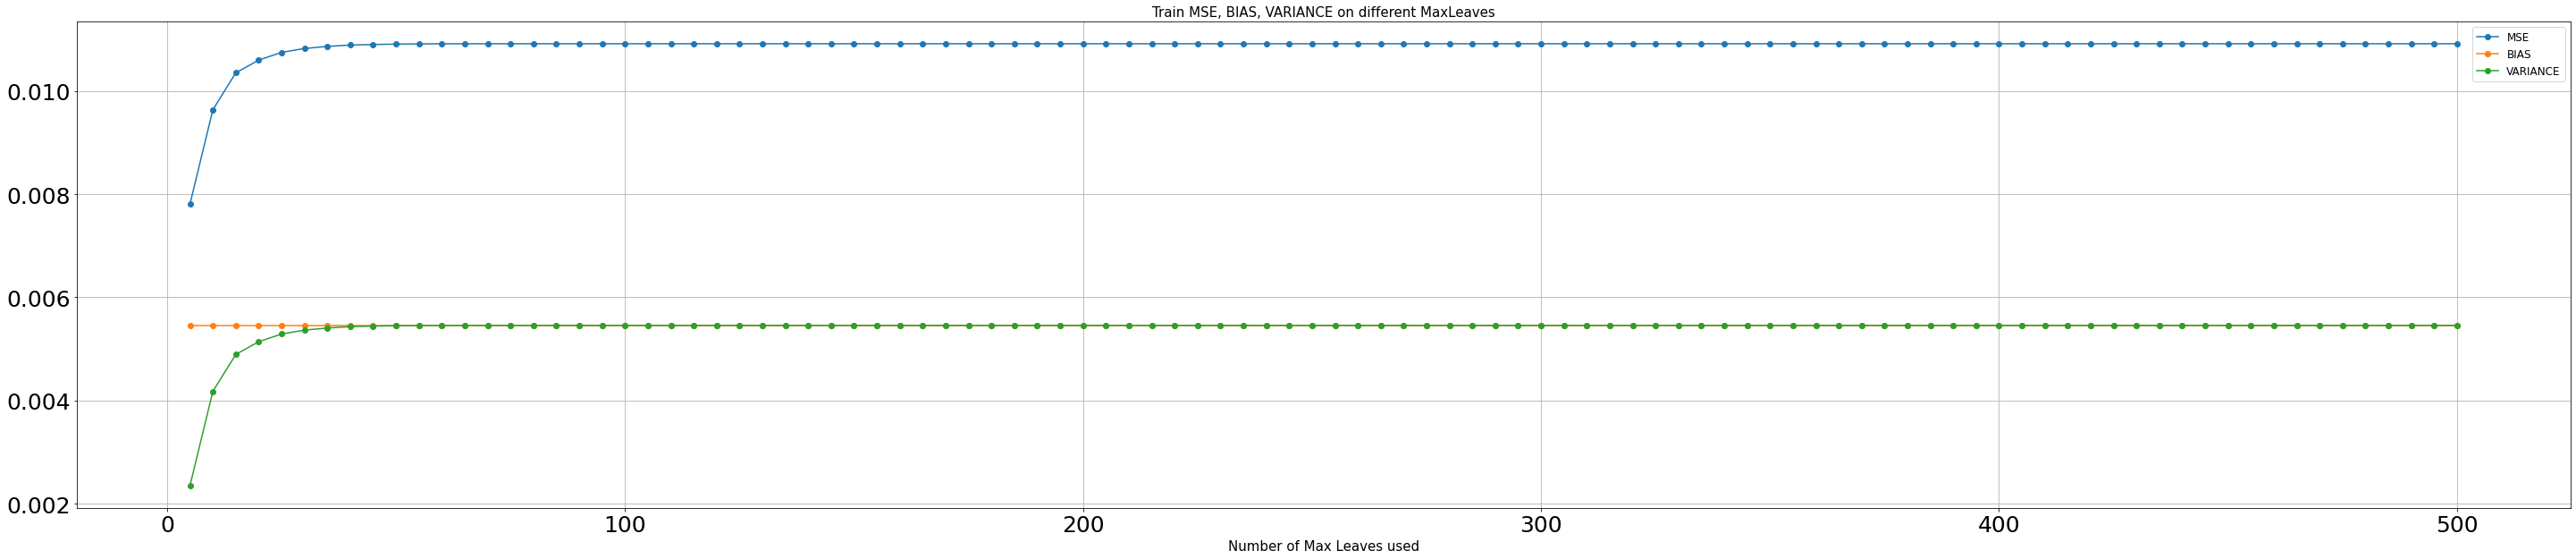

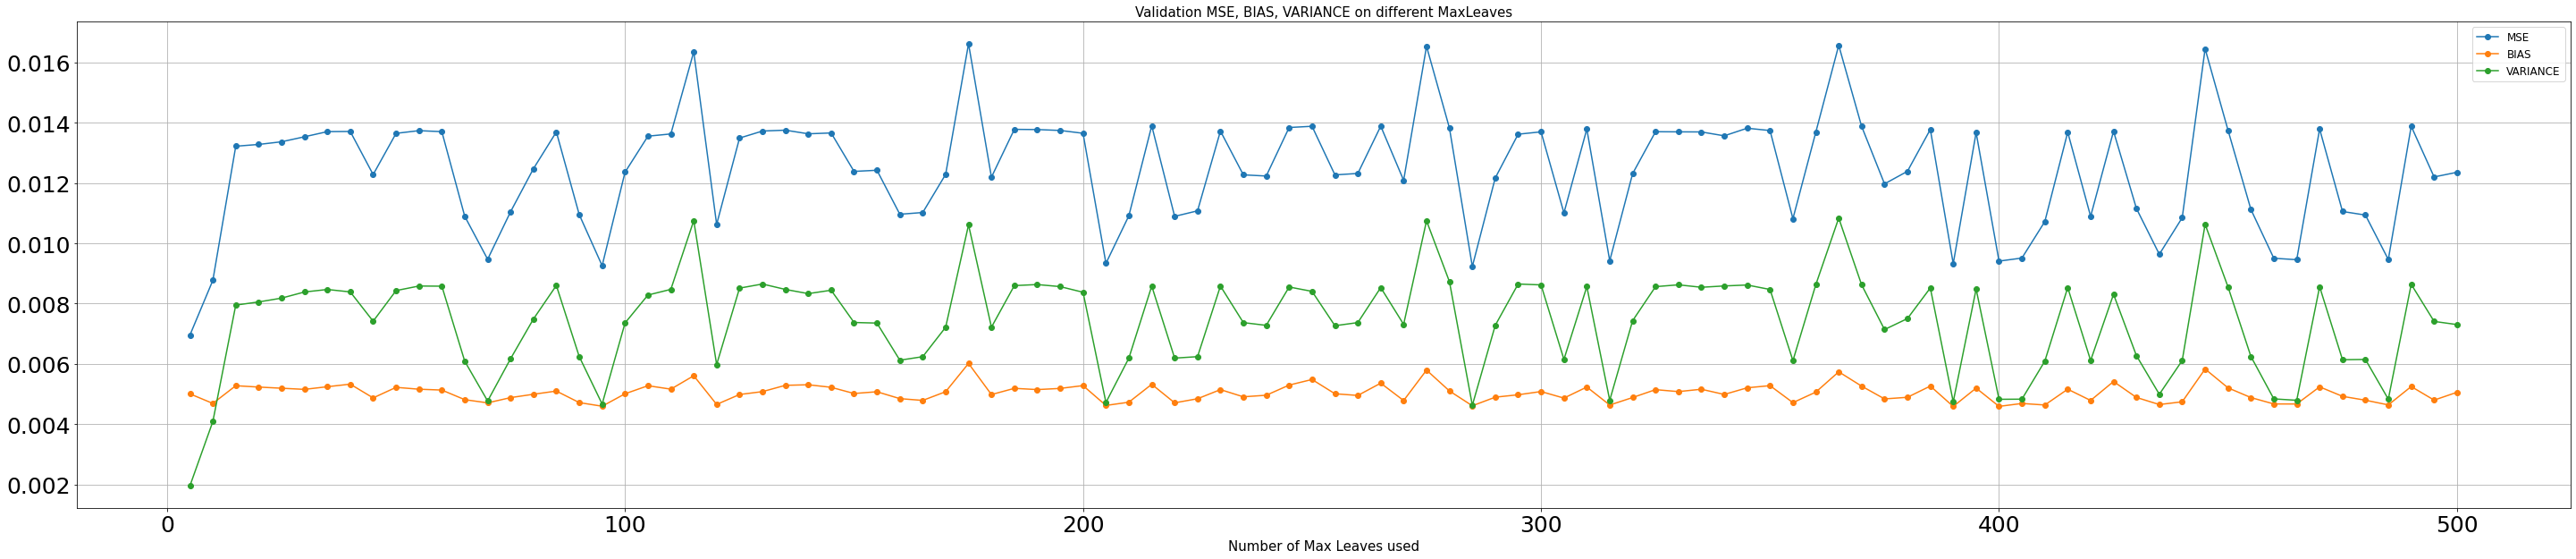

In [18]:
%%time
dt_model.append(
    get_dt(
        1,
        verbose   = False,
        debug     = False#,
        #file_name = 'prova1'
    )
)

Train: TUNING DEL MASSIMO NUMERO DI FOGLIE

Punteggio finale: 0.006839588164696593 (500) MaxLeaves
Best mse: 0.006224817157781893
Best number of MaxLeaves: 5

Punteggio finale: 0.0034197940823482965 (500) MaxLeaves
Best bias: 0.003419794082348296
Best number of MaxLeaves: 5

Punteggio finale: 0.0034197940823482965 (500) MaxLeaves
Best var: 0.0028050230754335962
Best number of MaxLeaves: 5

Validation: TUNING DEL MASSIMO NUMERO DI FOGLIE

Punteggio finale: 0.010137251190421054 (500) MaxLeaves
Best mse: 0.008975082051578953
Best number of MaxLeaves: 5

Punteggio finale: 0.007219481565165677 (500) MaxLeaves
Best bias: 0.007113669013471761
Best number of MaxLeaves: 285

Punteggio finale: 0.002917769625255375 (500) MaxLeaves
Best var: 0.001790027234258777
Best number of MaxLeaves: 5

Wall time: 638 ms


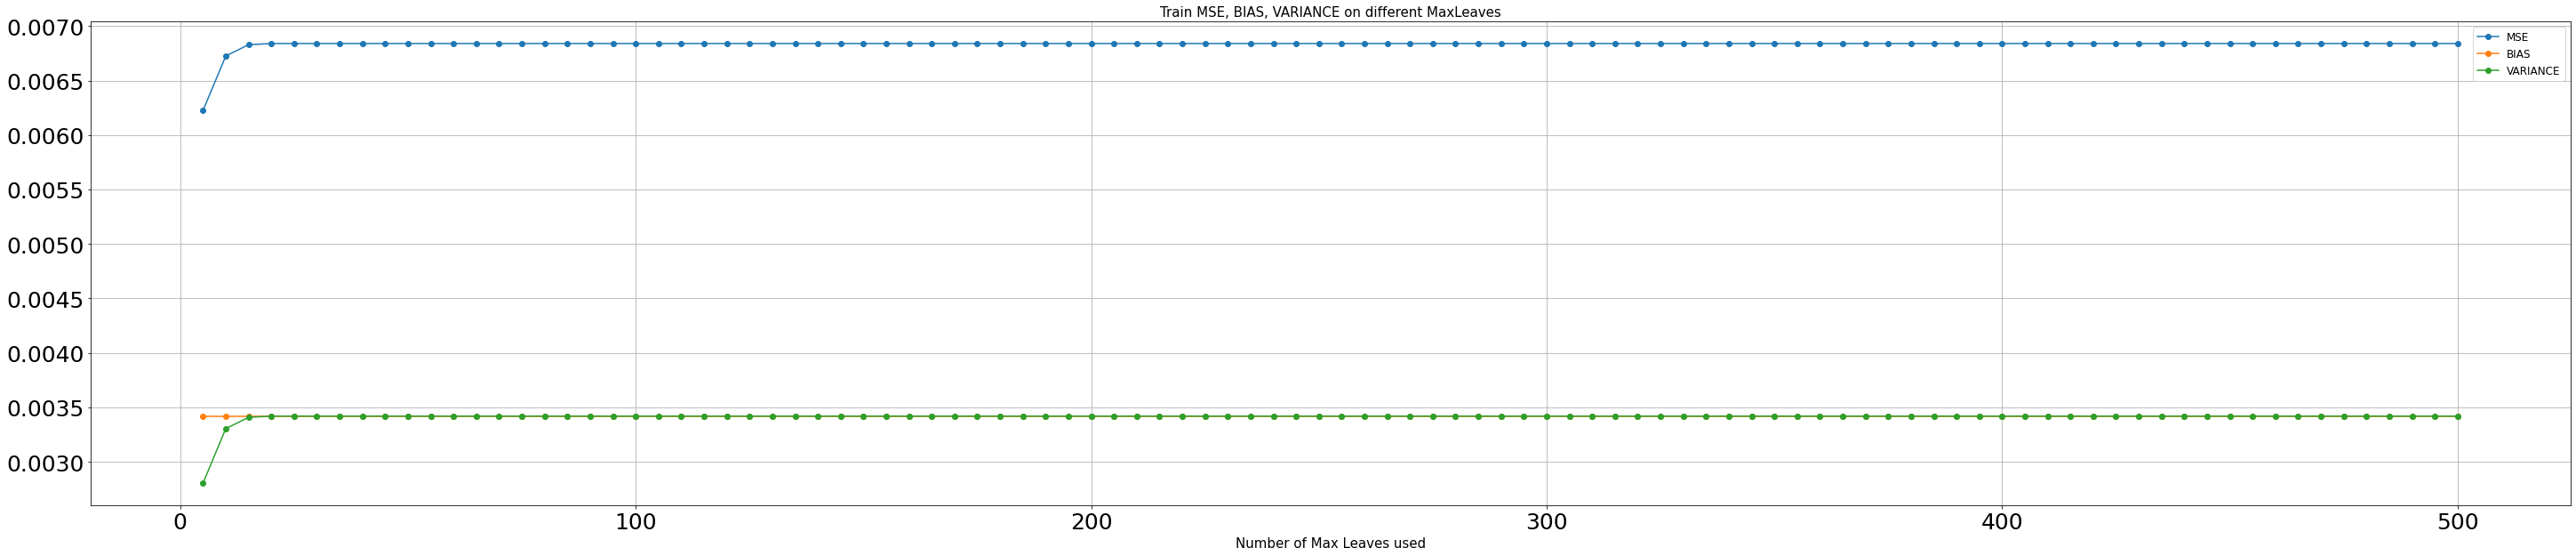

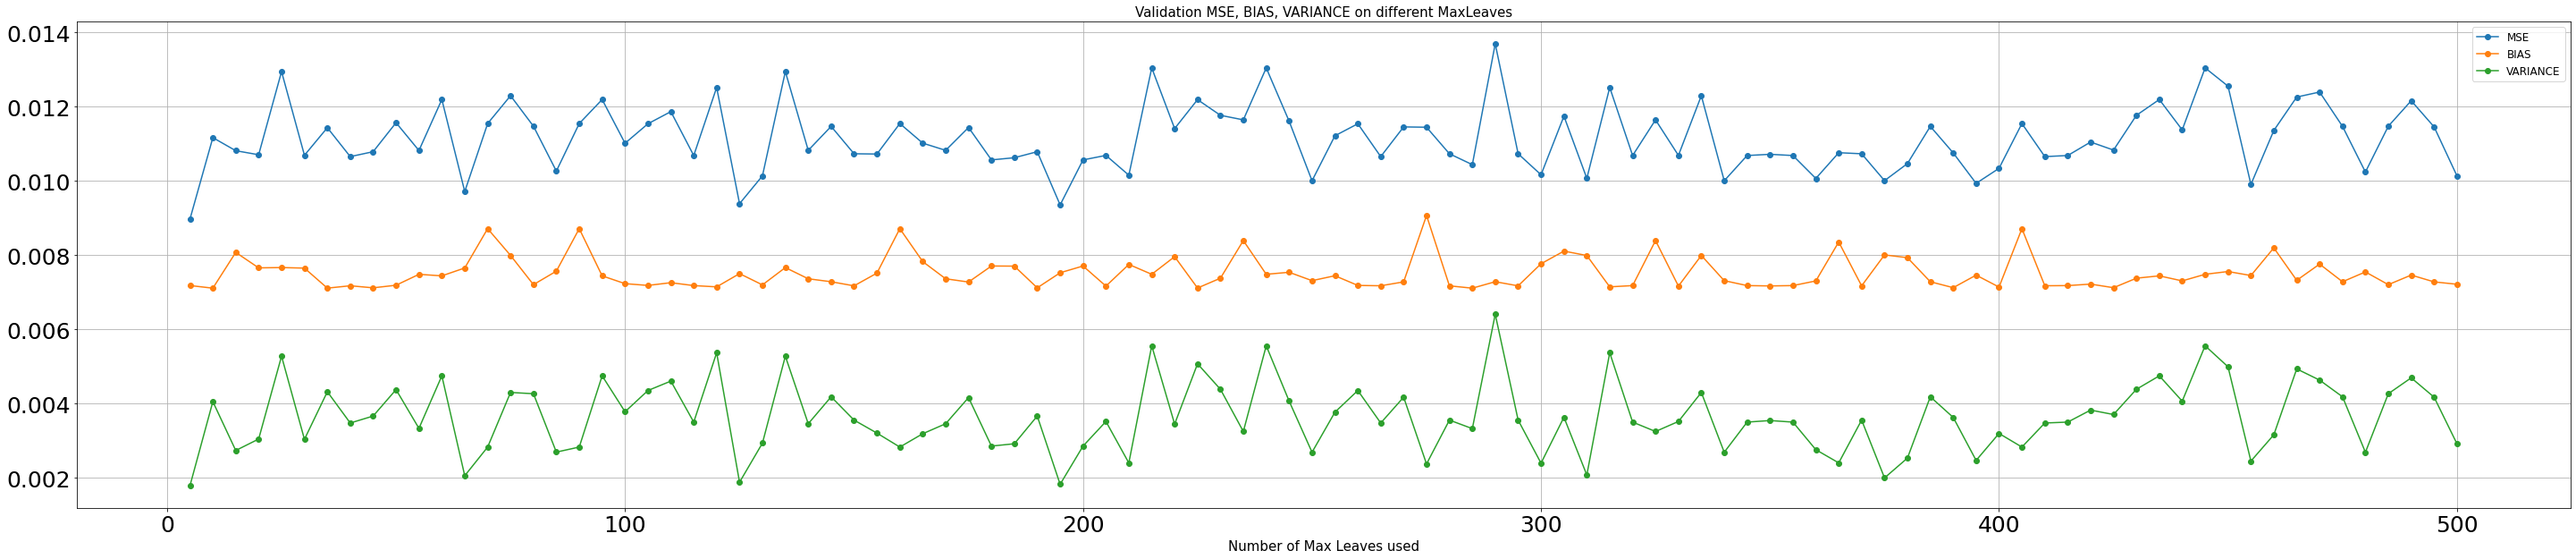

In [19]:
%%time
dt_model.append(
    get_dt(
        2,
        verbose   = False,
        debug     = False#,
        #file_name = 'prova2'
    )
)

In [20]:
dt_model

[DecisionTreeRegressor(max_leaf_nodes=305),
 DecisionTreeRegressor(max_leaf_nodes=5),
 DecisionTreeRegressor(max_leaf_nodes=5)]

In [21]:
def get_bias_var_mse(X, y, model):
        y_pred = model.predict(X)
        return {
            'bias': ((y - np.mean(y_pred))**2).mean(),\
            'var':  np.var(y_pred).mean(),\
            'mse':  ((y_pred - y.reshape(-1,1))**2).mean()
        }

In [22]:
def print_stats(X, y, models):
    for i in range(3):
        print(f'{region_names[i]}: {get_bias_var_mse(X[i], y[i].values.ravel(), models[i])}')
        print()

In [40]:
def print_all_stats(models):
    for X, y, name in zip(
        [X_train,        X_val, X_test],
        [y_train,        y_val, y_test],
        ['Train', 'Validation', 'Test']
    ):
        print(name)
        print()
        print_stats(X, y, models)
        print()
        

In [39]:
print_all_stats(dt_model)

Train

A: {'bias': 0.007221300454965437, 'var': 0.010754230618744587, 'mse': 0.017975531073710048}

B: {'bias': 0.008141988842626267, 'var': 0.0033822751596851485, 'mse': 0.011524264002311426}

C: {'bias': 0.011675398264604642, 'var': 0.0024962684617144764, 'mse': 0.014171666726319044}

Validation

A: {'bias': 0.027513599469742304, 'var': 0.011067982590468399, 'mse': 0.03858158206021075}

B: {'bias': 0.020304001114261123, 'var': 0.0032088668950137926, 'mse': 0.0235128680092749}

C: {'bias': 0.021717725127928675, 'var': 0.0025207561399931706, 'mse': 0.024238481267921903}

Test

A: {'bias': 0.028753879690179847, 'var': 0.010868483958170212, 'mse': 0.039622363648349916}

B: {'bias': 0.02505328844339022, 'var': 0.003162784642739067, 'mse': 0.028216073086129296}

C: {'bias': 0.029128449749849985, 'var': 0.0024870585901315165, 'mse': 0.03161550833998149}



L'errore sembra provenire principalmente dal bias: uso il boosting per ridurlo 

# Boosting #

In [59]:
def boosting_train(X_train, y_train, X_val, y_val, baseModel, verbose=False, debug=False, file_name=''):
    
    def get_adaboost_regressor(Xs, ys, estimators):
        adaboost = AdaBoostRegressor(
            baseModel,
            n_estimators = estimators
        )
        adaboost.fit(Xs,ys)
        return adaboost
    
    def bias_var_mse(X, y, model):
        stats = get_bias_var_mse(X, y, model)
        return stats['bias'],\
               stats['var'],\
               stats['mse']
    
    def plot_mse(stats, name):
    
        print (f'{name}: TUNING DEL NUMERO DI STIMATORI')
        print()
    
        for n in ['mse', 'bias', 'var']:
        
            min_  = min(stats[n])
            best  = (np.argmin(stats[n]) * STEP) + START
            
            print (f'Punteggio finale: {stats[n][-1]} ({END}) stimatori')
            print (f'Best {n}:, {min_}')
            print (f'Best number of Estimators: {best}')
            print()

        fig, ax = plt.subplots(figsize=(len(stats['mse'])/2, 10))
        
        ax.tick_params(axis='both', which='major', labelsize=25)
        ax.tick_params(axis='both', which='minor', labelsize=15)
        
        ax.plot(range(START, END+1, STEP),  stats['mse' ], 'o-', label='MSE')
        ax.plot(range(START, END+1, STEP),  stats['bias'], 'o-', label='BIAS')
        ax.plot(range(START, END+1, STEP),  stats['var' ], 'o-', label='VARIANCE')
        
        ax.set_title(f'{name}: MSE, BIAS, VARIANCE on different Estimators', fontsize=15)
        ax.set_xlabel("Number of Max Estimators used", fontsize=15)
        ax.grid()
        ax.legend(prop={'size': 12})
        
        if file_name != '':
            fig.savefig('images/' + file_name + '_AdaBoostRegressor_' + name + '.jpg')
        
    
    START       = 10
    END         = 500
    STEP        = 10
    N_TESTS     = 20
    #SAMPLE_PERC = 1/3 # 0.33
    SAMPLE_PERC = 2/3 # 0.67
    
    stats   = np.array([])
    boosts  = range(START, END+1, STEP)
    
    y_train = y_train.values.ravel()
    y_val   = y_val  .values.ravel()
    
    X_start, y_start = resample(X_train, y_train, n_samples = int(SAMPLE_PERC*len(y_train)))
    
    model_start = get_adaboost_regressor(X_start, y_start, START)
    
    _, _, best_mse = bias_var_mse(X_train, y_train, model_start)
    
    best_estimators = START
    best_model      = model_start
    
    info = []
    
    train_stats = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    }

    val_stats = {
        'bias' : [],
        'var'  : [],
        'mse'  : []
    }
    
    for b in boosts:
        
        if debug:
            print(f'{b}/{END}')
            
        train_stats_s = {
            'bias' : [],\
            'var'  : [],\
            'mse'  : []
        }

        val_stats_s = {
            'bias' : [],\
            'var'  : [],\
            'mse'  : []
        } 
        
        
        # Resampling
        for i in range(N_TESTS):
            
            if debug:
                print(f'    {i+1}/{N_TESTS}')
            
            X_sample, y_sample = resample(X_train, y_train, n_samples = int(SAMPLE_PERC*len(y_train)))

            ada = get_adaboost_regressor(X_sample, y_sample, b)
            
            trn_bias, trn_var, trn_mse = bias_var_mse(X_train, y_train, ada)
            val_bias, val_var, val_mse = bias_var_mse(  X_val,   y_val, ada)

            train_stats_s['bias'].append(trn_bias)
            train_stats_s['var' ].append(trn_var )
            train_stats_s['mse' ].append(trn_mse )
            
            val_stats_s  ['bias'].append(val_bias)
            val_stats_s  ['var' ].append(val_var )
            val_stats_s  ['mse' ].append(val_mse )
            
            
        trn_bias_s = np.array(train_stats_s['bias']).mean()
        trn_var_s  = np.array(train_stats_s['var' ]).mean()
        trn_mse_s  = np.array(train_stats_s['mse' ]).mean()
        
        val_bias_s = np.array(  val_stats_s['bias']).mean()
        val_var_s  = np.array(  val_stats_s['var' ]).mean()
        val_mse_s  = np.array(  val_stats_s['mse' ]).mean()
        
            
        train_stats['bias'].append(trn_bias_s)
        train_stats['var' ].append(trn_var_s )
        train_stats['mse' ].append(trn_mse_s )
            
        val_stats  ['bias'].append(val_bias_s)
        val_stats  ['var' ].append(val_var_s )
        val_stats  ['mse' ].append(val_mse_s )
        
        
        info.append (
            f'Estimators: {b}' +\
            f"\n(Train MSE:      {trn_mse_s } - Val MSE:      {val_mse_s })" +\
            f"\n(Train Bias:     {trn_bias_s} - Val Bias:     {val_bias_s})" +\
            f"\n(Train Variance: {trn_var_s } - Val Variance: {val_var_s })"
        )
        
        
        if(val_mse_s < best_mse):
            best_mse = val_mse_s
            best_estimators = b
            best_model = get_adaboost_regressor(X_train, y_train, b)
            
    if verbose:
        print(*info, sep='\n')
        
    plot_mse(train_stats, 'Train')
    plot_mse(val_stats, 'Validation') 
    
    return best_model

In [60]:
boost_model = []

In [2]:
def get_bmodel(index, verbose=False, debug=False, file_name=''):
    if file_name == '':
        file_name = region_ids[index]
    return boosting_train(
        X_train_sub [index],
        y_train_sub [index],
        X_val_sub   [index],
        y_val_sub   [index],
        dt_model[index],
        verbose   = verbose,
        debug     = debug,
        file_name = file_name
    )

Sostituisco, miglior stimatore: 2
Sostituisco, miglior stimatore: 6
Sostituisco, miglior stimatore: 8
Sostituisco, miglior stimatore: 12
Sostituisco, miglior stimatore: 16
Sostituisco, miglior stimatore: 26
Sostituisco, miglior stimatore: 32
Sostituisco, miglior stimatore: 96
Train: TUNING DEL NUMERO DI STIMATORI

Punteggio finale: 0.013408636189171319 (100) stimatori
Best mse:, 0.011195754521251301
Best number of Estimators: 60

Punteggio finale: 0.007971980756663347 (100) stimatori
Best bias:, 0.007859910561967502
Best number of Estimators: 82

Punteggio finale: 0.005436655432507973 (100) stimatori
Best var:, 0.0030029725689924834
Best number of Estimators: 52

Validation: TUNING DEL NUMERO DI STIMATORI

Punteggio finale: 0.006781360771979128 (100) stimatori
Best mse:, 0.005585712979078599
Best number of Estimators: 96

Punteggio finale: 0.004358810973536537 (100) stimatori
Best bias:, 0.0036750511134348695
Best number of Estimators: 12

Punteggio finale: 0.0024225497984425907 (100) 

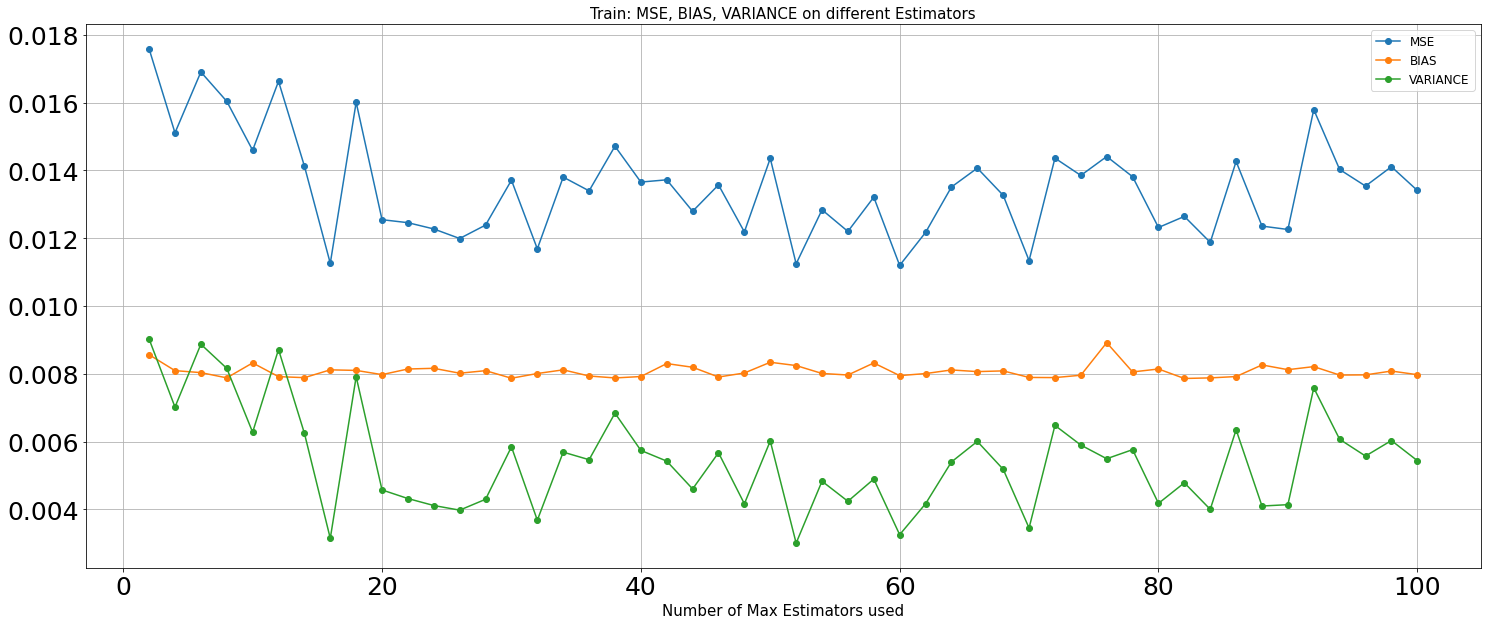

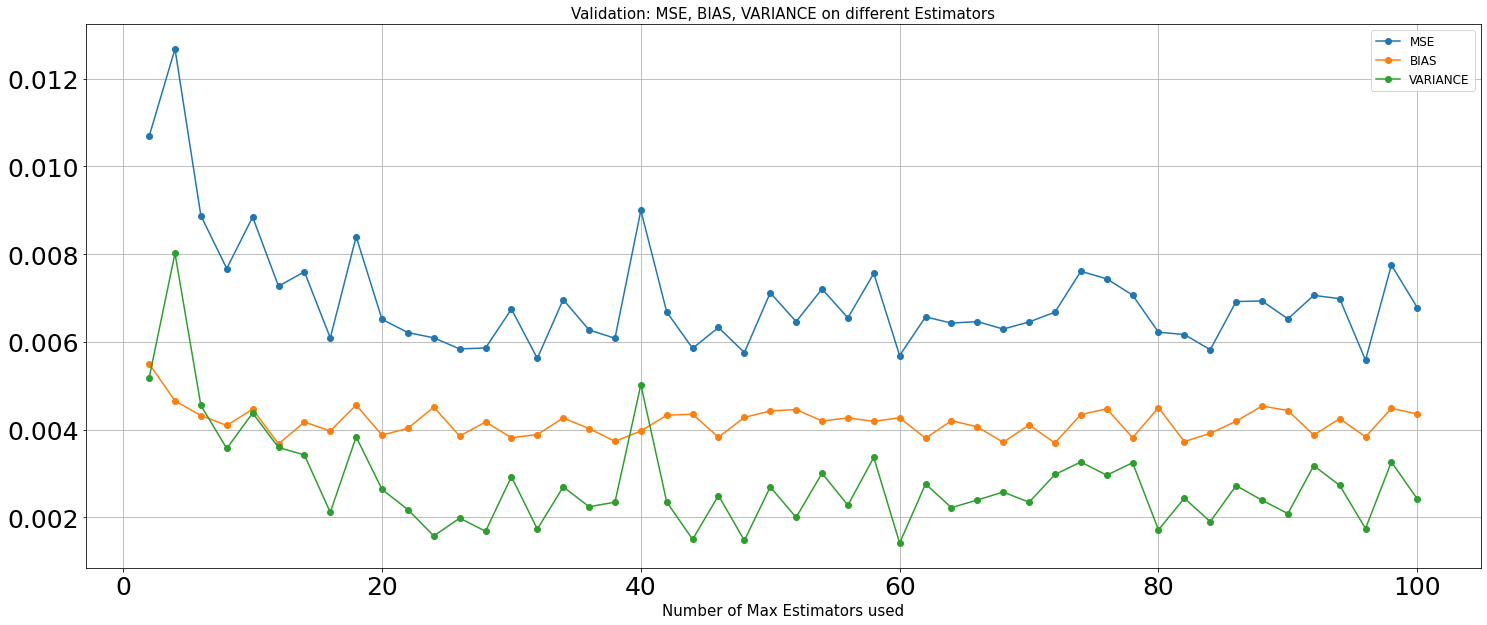

In [62]:
%%time
boost_model.append(
    get_bmodel(
        0,
        verbose   = False,
        debug     = False#,
        #file_name = 'Prova1'
    )        
)

Sostituisco, miglior stimatore: 2
Sostituisco, miglior stimatore: 4
Sostituisco, miglior stimatore: 6
Sostituisco, miglior stimatore: 10
Sostituisco, miglior stimatore: 12
Sostituisco, miglior stimatore: 100
Train: TUNING DEL NUMERO DI STIMATORI

Punteggio finale: 0.008152569587448632 (100) stimatori
Best mse:, 0.007620466360752652
Best number of Estimators: 90

Punteggio finale: 0.005497870033144671 (100) stimatori
Best bias:, 0.0054781162728081605
Best number of Estimators: 80

Punteggio finale: 0.00265469955430396 (100) stimatori
Best var:, 0.002060407165817996
Best number of Estimators: 90

Validation: TUNING DEL NUMERO DI STIMATORI

Punteggio finale: 0.005322035136783294 (100) stimatori
Best mse:, 0.005322035136783294
Best number of Estimators: 100

Punteggio finale: 0.004780413956561329 (100) stimatori
Best bias:, 0.004768125121223619
Best number of Estimators: 12

Punteggio finale: 0.0005416211802219652 (100) stimatori
Best var:, 0.0005416211802219652
Best number of Estimators: 

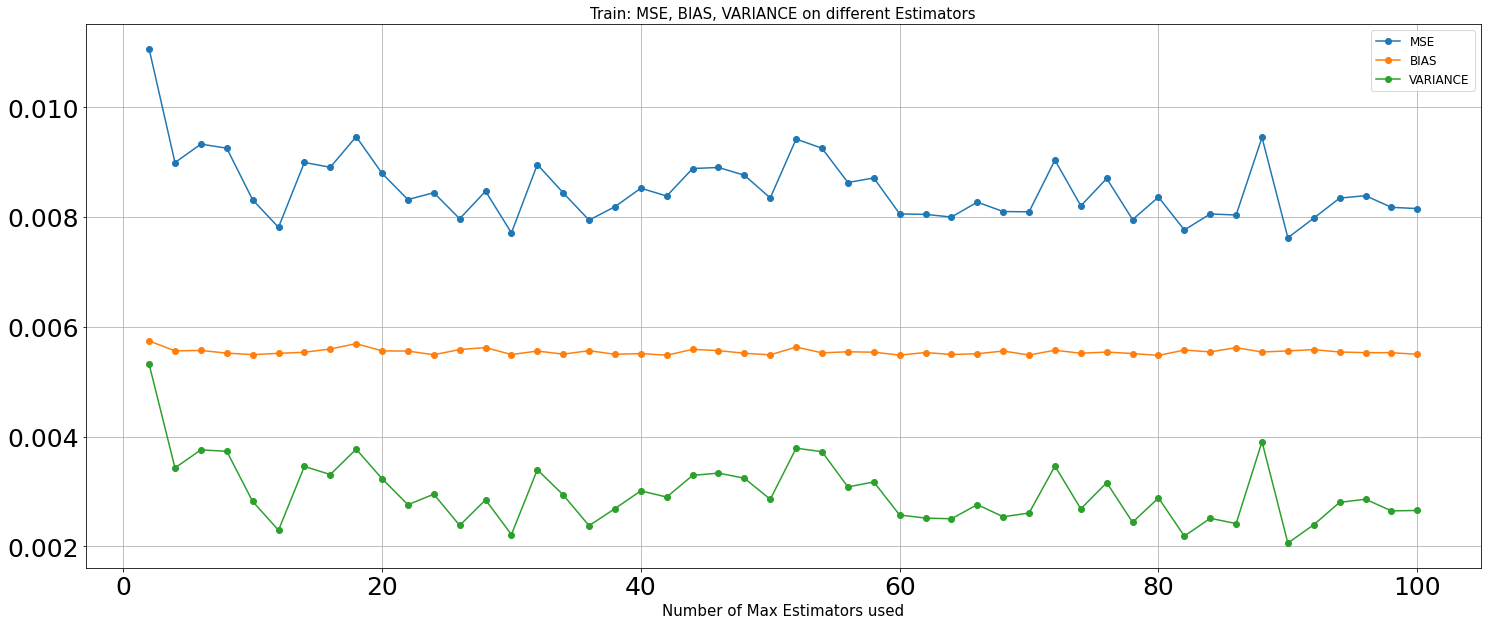

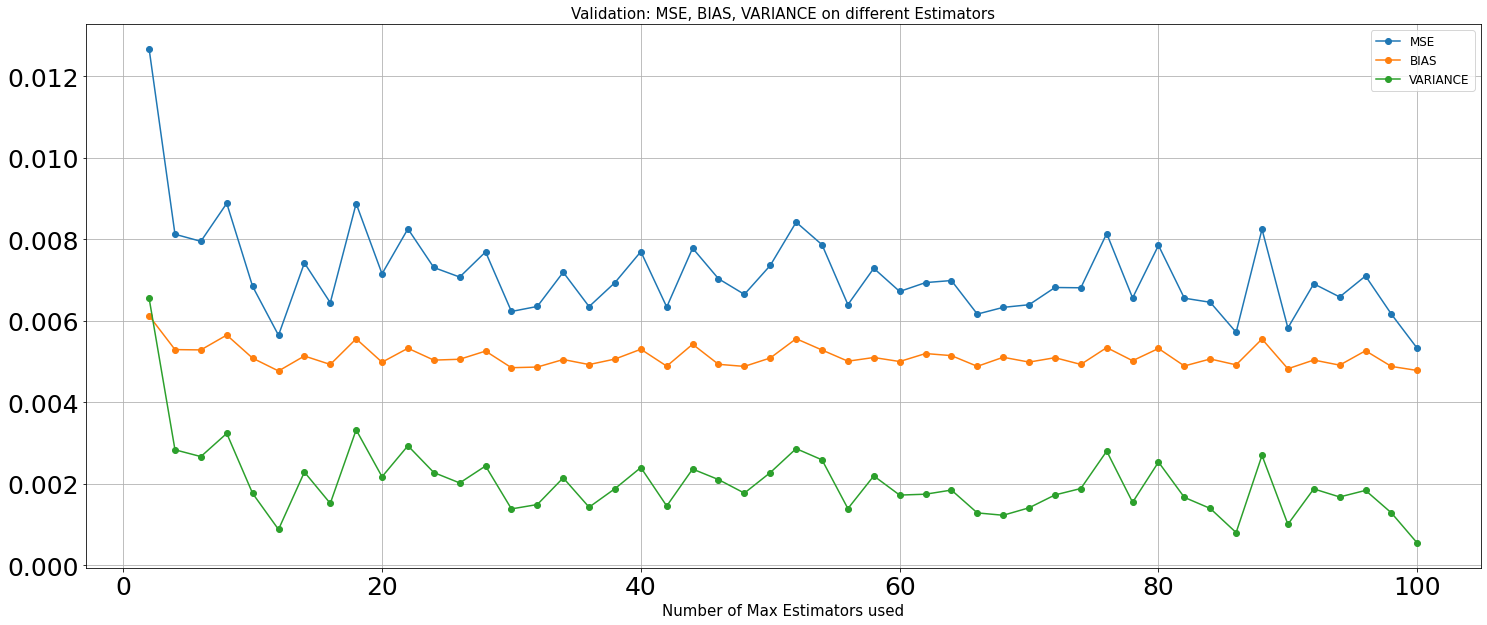

In [63]:
%%time
boost_model.append(
    get_bmodel(
        1,
        verbose   = False,
        debug     = False#,
        #file_name = 'Prova2'
    )        
)

Sostituisco, miglior stimatore: 4
Sostituisco, miglior stimatore: 8
Sostituisco, miglior stimatore: 10
Sostituisco, miglior stimatore: 24
Sostituisco, miglior stimatore: 34
Sostituisco, miglior stimatore: 54
Train: TUNING DEL NUMERO DI STIMATORI

Punteggio finale: 0.005629738505100972 (100) stimatori
Best mse:, 0.004754140056949125
Best number of Estimators: 96

Punteggio finale: 0.0035205570115753823 (100) stimatori
Best bias:, 0.003450421061285091
Best number of Estimators: 84

Punteggio finale: 0.0021091814935255892 (100) stimatori
Best var:, 0.0012529684970426231
Best number of Estimators: 96

Validation: TUNING DEL NUMERO DI STIMATORI

Punteggio finale: 0.00861016719108639 (100) stimatori
Best mse:, 0.008505701689578747
Best number of Estimators: 54

Punteggio finale: 0.007846482060826259 (100) stimatori
Best bias:, 0.007528197279168288
Best number of Estimators: 10

Punteggio finale: 0.000763685130260132 (100) stimatori
Best var:, 0.0006411626742154434
Best number of Estimators: 

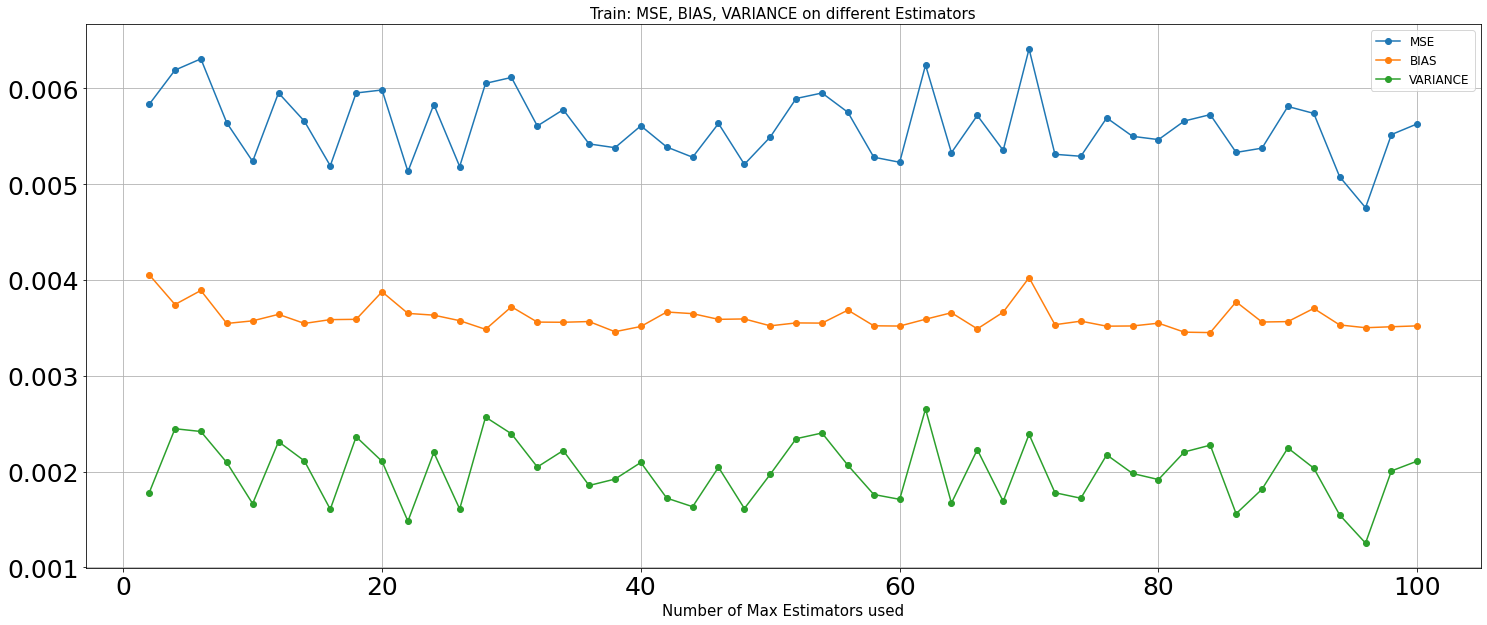

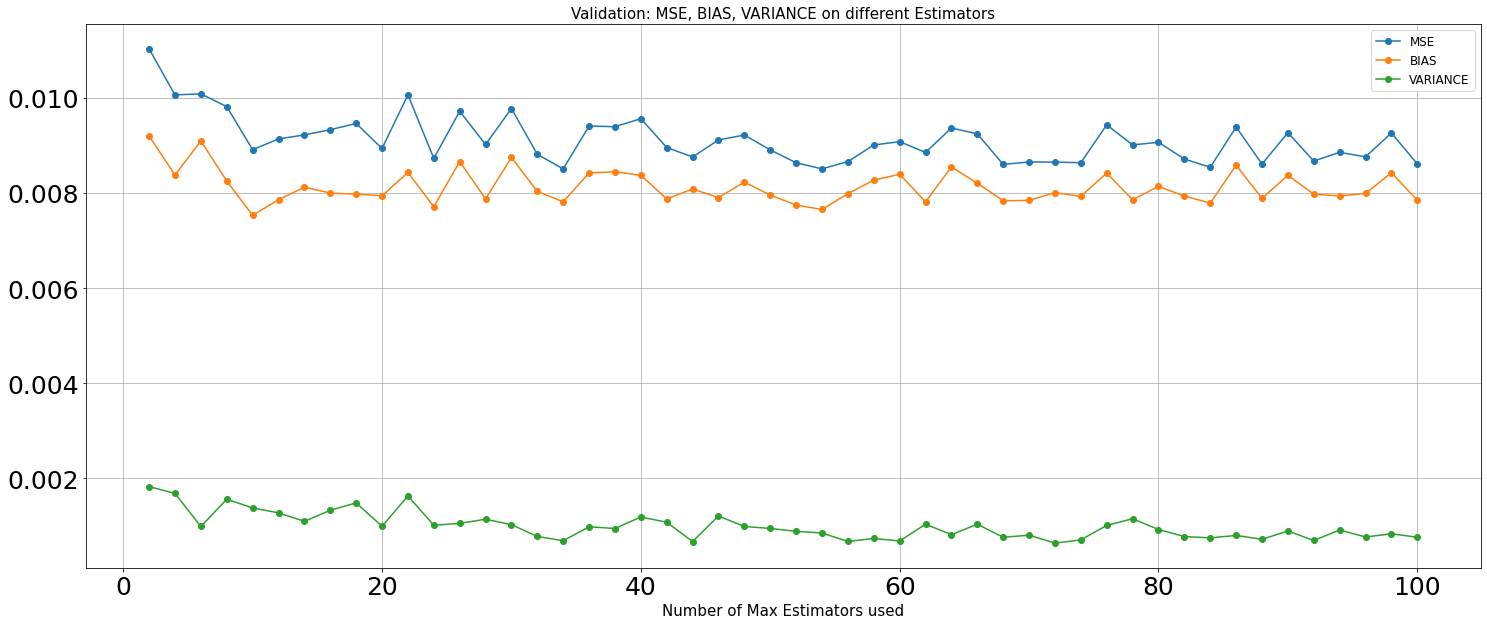

In [64]:
%%time
boost_model.append(
    get_bmodel(
        2,
        verbose   = False,
        debug     = False#,
        #file_name = 'Prova2'
    )        
)

In [65]:
boost_model

[AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_leaf_nodes=305),
                   n_estimators=96),
 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_leaf_nodes=5),
                   n_estimators=100),
 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_leaf_nodes=5),
                   n_estimators=54)]

In [66]:
print_all_stats(boost_model)

Train

A: {'bias': 0.007027959770654382, 'var': 0.0048435370902942705, 'mse': 0.011871496860948624}

B: {'bias': 0.007619787642011745, 'var': 0.0006722115571307858, 'mse': 0.008291999199142511}

C: {'bias': 0.011383113659180894, 'var': 0.0005623056831588027, 'mse': 0.011945419342339706}


Validation

A: {'bias': 0.027343026776327786, 'var': 0.0049336809190461866, 'mse': 0.032276707695374}

B: {'bias': 0.019723798902842635, 'var': 0.0004991300352601874, 'mse': 0.020222928938102812}

C: {'bias': 0.021443139333046375, 'var': 0.0005663083725167451, 'mse': 0.022009447705563148}


Test

A: {'bias': 0.028647111197142482, 'var': 0.004818571684552552, 'mse': 0.03346568288169485}

B: {'bias': 0.024339667206707796, 'var': 0.0006037804018419992, 'mse': 0.024943447608549798}

C: {'bias': 0.028746824875925624, 'var': 0.0005750249558095153, 'mse': 0.029321849831735164}


